# Part 1: Data Ingestion

This demo showcases financial fraud prevention and using the MLRun feature store to define complex features that help identify fraud. Fraud prevention specifically is a challenge as it requires processing raw transaction and events in real-time and being able to quickly respond and block transactions before they occur.

The raw data is described as follows:

| TRANSACTIONS                                                                    || &#x2551; |EVENTS                                                                           || 
|-----------------|----------------------------------------------------------------|----------|-----------------|----------------------------------------------------------------|
| **age**         | age group value 0-6. Some values are marked as U for unknown   | &#x2551; | **source**      | The party/entity related to the event                          |
| **gender**      | A character to define the age                                  | &#x2551; | **event**       | event, such as login or password change                        |
| **zipcodeOri**  | ZIP code of the person originating the transaction             | &#x2551; | **timestamp**   | The date and time of the event                                 |
| **zipMerchant** | ZIP code of the merchant receiving the transaction             | &#x2551; |                 |                                                                |
| **category**    | category of the transaction (e.g., transportation, food, etc.) | &#x2551; |                 |                                                                |
| **amount**      | the total amount of the transaction                            | &#x2551; |                 |                                                                |
| **fraud**       | whether the transaction is fraudulent                          | &#x2551; |                 |                                                                |
| **timestamp**   | the date and time in which the transaction took place          | &#x2551; |                 |                                                                |
| **source**      | the ID of the party/entity performing the transaction          | &#x2551; |                 |                                                                |
| **target**      | the ID of the party/entity receiving the transaction           | &#x2551; |                 |                                                                |
| **device**      | the device ID used to perform the transaction                  | &#x2551; |                 |                                                                |


This notebook introduces how to **Ingest** different data sources to the **Feature Store**.

The following FeatureSets will be created:
- **Transactions**: Monetary transactions between a source and a target.
- **Events**: Account events such as account login or a password change.
- **Label**: Fraud label for the data.

By the end of this tutorial you’ll learn how to:

- Create an ingestion pipeline for each data source.
- Define preprocessing, aggregation and validation of the pipeline.
- Run the pipeline locally within the notebook.
- Launch a real-time function to ingest live data.
- Schedule a cron to run the task when needed.

## Initializing Your MLRun Environment

Run the following code to initialize your MLRun environment to use a “getting-started-tutorial-<username>” project and store the project artifacts in the default artifacts path:

In [1]:
import mlrun

project_name, artifact_path  = mlrun.set_environment(project='fraud-demo', user_project=True)

# Display the current project name and artifacts path
print(f'Project name: {project_name}')
print(f'Artifacts path: {artifact_path}')

Project name: fraud-demo-gilads
Artifacts path: v3io:///projects/{{run.project}}/artifacts


The following helper function is part of the demo to adjust the data's date ranges to be relative to now.

In [2]:
# Helper functions to adjust the timestamps of our data
# while keeping the order of the selected events and
# the relative distance from one event to the other

def date_adjustment(sample, data_max, new_max, old_data_period, new_data_period):
    '''
        Adjust a specific sample's date according to the original and new time periods
    '''
    sample_dates_scale = ((data_max - sample) / old_data_period)
    sample_delta = new_data_period * sample_dates_scale
    new_sample_ts = new_max - sample_delta
    return new_sample_ts

def adjust_data_timespan(dataframe, timestamp_col='timestamp', new_period='2d', new_max_date_str='now'):
    '''
        Adjust the dataframe timestamps to the new time period
    '''
    # Calculate old time period
    data_min = dataframe.timestamp.min()
    data_max = dataframe.timestamp.max()
    old_data_period = data_max-data_min
    
    # Set new time period
    new_time_period = pd.Timedelta(new_period)
    new_max = pd.Timestamp(new_max_date_str)
    new_min = new_max-new_time_period
    new_data_period = new_max-new_min
    
    # Apply the timestamp change
    df = dataframe.copy()
    df[timestamp_col] = df[timestamp_col].apply(lambda x: date_adjustment(x, data_max, new_max, old_data_period, new_data_period))
    return df

## Define the Real-Time Credit Transactions Feature Set (data pipeline)



### Load and view the credit transaction data


In [3]:
import pandas as pd

# Load the dataset
data = pd.read_csv('https://s3.wasabisys.com/iguazio/data/fraud-demo-mlrun-fs-docs/data.csv', parse_dates=['timestamp'])

# Sample 50k lines
data = data.sample(50000)

# Adjust the samples timestamp for the past 2 days
data = adjust_data_timespan(data, new_period='2d')

data.head()

,step,age,gender,zipcodeOri,zipMerchant,category,amount,fraud,timestamp,source,target,device
149292,52,2,F,28007,28007,es_transportation,13.86,0,2021-08-10 20:44:30.389560918,C1403689550,M348934600,a02bc7a9e1f648e4a9cdd964900df909
35479,13,3,M,28007,28007,es_transportation,13.02,0,2021-08-10 11:41:39.533966945,C582022575,M348934600,d80792380b3a4a6d9b91f951ef1b95e6
453990,141,1,F,28007,28007,es_transportation,38.71,0,2021-08-10 22:36:27.685788233,C34104097,M348934600,644f7a0cb9c142cb93dc058c8ad3527d
143878,51,4,F,28007,28007,es_transportation,47.68,0,2021-08-11 04:00:31.521523149,C193297871,M1823072687,3efcf0f8c4b444258050eb772f54a1f0
48798,18,2,M,28007,28007,es_transportation,23.36,0,2021-08-11 02:43:48.313081401,C344248234,M348934600,4ed3a6b0c51948b9883f7a9928b5d128


### Build and run the pipeline

Import MLRun's Feature Store

In [4]:
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import OneHotEncoder, MapValues, DateExtractor

Create the FeatureSet (data pipeline) definition for the **credit transaction processing** which describes the offline/online data transformations and aggregations.<br>
The feature store will automatically add an offline `parquet` target and an online `NoSQL` target by using `set_targets()`.

The data pipeline consists of:

* **Extracting** the data components (hour, day of week)
* **Mapping** the age values
* **One hot encoding** for the transaction category and the gender
* **Aggregating** the amount (avg, sum, count, max over 2/12/24 hour time windows)
* **Aggregating** the transactions per category (over 14 days time windows)
* **Writing** the results to **offline** (Parquet) and **online** (NoSQL) targets 

In [5]:
# Define and add value mapping
main_categories = ["es_transportation", "es_health", "es_otherservices",
       "es_food", "es_hotelservices", "es_barsandrestaurants",
       "es_tech", "es_sportsandtoys", "es_wellnessandbeauty",
       "es_hyper", "es_fashion", "es_home", "es_contents",
       "es_travel", "es_leisure"]

# One Hot Encode the newly defined mappings
one_hot_encoder_mapping = {'category': main_categories,
                           'gender': list(data.gender.unique())}

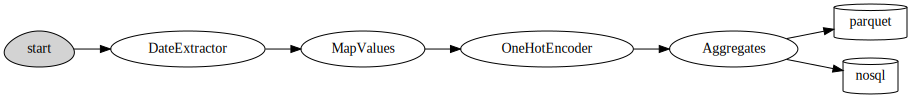

In [6]:
# Define the transactions FeatureSet
transaction_set = fstore.FeatureSet("transactions", 
                                    entities=[fstore.Entity("source")], 
                                    timestamp_key='timestamp', 
                                    description="transactions feature set")

# Define the graph steps
transaction_set.graph\
    .to(DateExtractor(parts = ['hour', 'day_of_week'], timestamp_col = 'timestamp'))\
    .to(MapValues(mapping={'age': {'U': '0'}}, with_original_features=True))\
    .to(OneHotEncoder(mapping=one_hot_encoder_mapping))


# Add aggregations for 2, 12, and 24 hour time windows
transaction_set.add_aggregation(name='amount',
                                column='amount',
                                operations=['avg','sum', 'count','max'],
                                windows=['2h', '12h', '24h'],
                                period='1h')


# Add the category aggregations over a 14 day window
for category in main_categories:
    transaction_set.add_aggregation(name=category,column=f'category_{category}',
                                    operations=['count'], windows=['14d'], period='1d')

# Add default (offline-parquet & online-nosql) targets
transaction_set.set_targets()

# Plot the pipeline so we can see the different steps
transaction_set.plot(rankdir="LR", with_targets=True)

**Now we ingested our data to the feature store and view the transformed data:**

In [7]:
# Use our dataframe as datasource and ingest it through our previously defined pipeline
resp = fstore.ingest(transaction_set, data, 
                     infer_options=fstore.InferOptions.default())

resp.head()

,amount_count_2h,amount_count_12h,amount_count_24h,amount_max_2h,amount_max_12h,amount_max_24h,amount_sum_2h,amount_sum_12h,amount_sum_24h,amount_avg_2h,...,category_es_contents,category_es_travel,category_es_leisure,amount,fraud,timestamp,target,device,timestamp_hour,timestamp_day_of_week
source,,,,,,,,,,,,,,,,,,,,,
C1403689550,1.0,1.0,1.0,13.86,13.86,13.86,13.86,13.86,13.86,13.86,...,0,0,0,13.86,0,2021-08-10 20:44:30.389560918,M348934600,a02bc7a9e1f648e4a9cdd964900df909,20,1
C582022575,1.0,1.0,1.0,13.02,13.02,13.02,13.02,13.02,13.02,13.02,...,0,0,0,13.02,0,2021-08-10 11:41:39.533966945,M348934600,d80792380b3a4a6d9b91f951ef1b95e6,11,1
C34104097,1.0,1.0,1.0,38.71,38.71,38.71,38.71,38.71,38.71,38.71,...,0,0,0,38.71,0,2021-08-10 22:36:27.685788233,M348934600,644f7a0cb9c142cb93dc058c8ad3527d,22,1
C193297871,1.0,1.0,1.0,47.68,47.68,47.68,47.68,47.68,47.68,47.68,...,0,0,0,47.68,0,2021-08-11 04:00:31.521523149,M1823072687,3efcf0f8c4b444258050eb772f54a1f0,4,2
C344248234,1.0,1.0,1.0,23.36,23.36,23.36,23.36,23.36,23.36,23.36,...,0,0,0,23.36,0,2021-08-11 02:43:48.313081401,M348934600,4ed3a6b0c51948b9883f7a9928b5d128,2,2


## Define and Ingest the User Events Feature Set

This feature set will contain all the user events related to the platform such as account logins, details or password change.

The first step will be to load our publicly available dataset:

In [8]:
# Load the events dataset
events = pd.read_csv('https://s3.wasabisys.com/iguazio/data/fraud-demo-mlrun-fs-docs/events.csv', index_col=0, quotechar="\'", parse_dates=['timestamp'])

# Adjust to the last 2 days to see the latest aggregations in our online feature vectors
events = adjust_data_timespan(events, new_period='2d')
events.head()

,source,event,timestamp
0,C1974668487,details_change,2021-08-10 15:26:52.605562086
1,C1973547259,login,2021-08-10 18:28:26.862702508
2,C515668508,login,2021-08-10 15:01:33.143879302
3,C1721541488,details_change,2021-08-10 17:09:03.253096221
4,C394979408,password_change,2021-08-10 18:46:51.300519667


### Build the events feature set and ingest data

Define the events feature set.
This is a relatively straight forward pipeline that only one hot encodes the event categories and saves the data to the default targets.

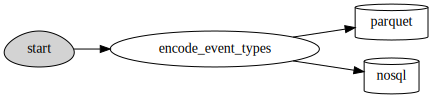

In [9]:
events_set = fstore.FeatureSet("events",
                               entities=[fstore.Entity("source")],
                               timestamp_key='timestamp', 
                               description="events feature set")

# Define and add value mapping
events_mapping = {'event': list(events.event.unique())}

# One Hot Encode
events_set.graph.to(OneHotEncoder(mapping=events_mapping), name='encode_event_types')

events_set.set_targets()
events_set.plot(rankdir="LR", with_targets=True)

In [10]:
# Ingestion of our newly created events feature set
events_df = fstore.ingest(events_set, events)

In [11]:
events_df.head()

,event_details_change,event_login,event_password_change,timestamp
source,,,,
C1974668487,1,0,0,2021-08-10 15:26:52.605562086
C1973547259,0,1,0,2021-08-10 18:28:26.862702508
C515668508,0,1,0,2021-08-10 15:01:33.143879302
C1721541488,1,0,0,2021-08-10 17:09:03.253096221
C394979408,0,0,1,2021-08-10 18:46:51.300519667


### Create a labels dataset for model training

This feature set contains the label for the fraud demo, it will be ingested directly to the default targets without any changes

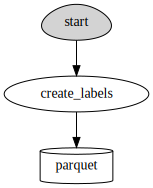

In [12]:
# Define the `labels` feature set
labels_set = fstore.FeatureSet("labels", 
                               entities=[fstore.Entity("source")], 
                               timestamp_key='timestamp',
                               description="training labels",
                               engine="pandas")

def create_labels(df):
    labels = df[['fraud','source','timestamp']].copy()
    labels = labels.rename(columns={"fraud": "label"})
    labels['timestamp'] = labels['timestamp'].astype("datetime64[ms]")
    labels['label'] = labels['label'].astype(int)
    labels.set_index('source', inplace=True)
    return labels


labels_set.graph.to(name="create_labels", handler=create_labels)

# specify only Parquet (offline) target since its not used for real-time
labels_set.set_targets(['parquet'], with_defaults=False)
labels_set.plot(with_targets=True)

In [13]:
# preview the resulting labels (will not write to data to the feature store)
fstore.preview(labels_set, data)

,label,timestamp
source,,
C1403689550,0,2021-08-10 20:44:30.389
C582022575,0,2021-08-10 11:41:39.533
C34104097,0,2021-08-10 22:36:27.685
C193297871,0,2021-08-11 04:00:31.521
C344248234,0,2021-08-11 02:43:48.313
...,...,...
C851871528,0,2021-08-09 17:58:04.519
C1706918687,0,2021-08-11 04:09:44.588
C17589297,0,2021-08-10 23:17:51.133


In [14]:
# Ingest the labels feature set
df = fstore.ingest(labels_set, data)

## Deploy as real-time pipeline

When dealing with real-time aggregation, it's important to be able to update these aggregations in real-time.
For this purpose, we will create live serving functions that will update the online feature store of the `transactions` FeatureSet and `Events` FeatureSet.

Using MLRun's `serving` runtime, craetes a nuclio function loaded with our feature set's computational graph definition
and an `HttpSource` to define the HTTP trigger.

Notice that the implementation below does not require any rewrite of the pipeline logic.

### Deploy transactions feature set live endpoint

Create iguazio V3IO stream `transaction_stream` to send and receive data in realt-time and a transactions push API endpoint `transaction_pusher` to send data
to the stream

In [15]:
transaction_stream = f'v3io:///projects/{project_name}/streams/transaction'
transaction_pusher = mlrun.datastore.get_stream_pusher(transaction_stream)

Define the HTTP Source to_dictable the HTTP trigger on our function and expose the endpoint.
As any other datasource, we will define the `key` and `time` fields here too.

In [16]:
http_source = mlrun.datastore.sources.HttpSource(key_field='source', time_field='timestamp')
transaction_set.spec.source = http_source

Create a real-time serverless function definition to deploy the ingestion pipeline on.
The serving runtimes enables the deployment of our feature set's computational graph.

In [17]:
function = mlrun.new_function('ingest-transactions', kind='serving', image='mlrun/mlrun')

function.with_code(body=" ")  # empty code since there are no custom classes/functions (cannot be "")

# Add stream trigger (must first create the stream)
function.add_v3io_stream_trigger(transaction_stream)

run_config = fstore.RunConfig(function=function, local=False).apply(mlrun.mount_v3io())

Deploy the transactions feature set's ingestion service using the feature set
and all the defined resources above.

In [18]:
transaction_set_endpoint = fstore.deploy_ingestion_service(featureset=transaction_set,
                                                       #source=http_source,
                                                       run_config=run_config)

> 2021-08-11 06:20:12,912 [info] Starting remote function deploy
2021-08-11 06:20:13  (info) Deploying function
2021-08-11 06:20:13  (info) Building
2021-08-11 06:20:13  (info) Staging files and preparing base images
2021-08-11 06:20:13  (info) Building processor image
2021-08-11 06:20:15  (info) Build complete
2021-08-11 06:20:21  (info) Function deploy complete
> 2021-08-11 06:20:23,495 [info] function deployed, address=default-tenant.app.product-v301.iguazio-cd0.com:30389


### Test the feature set HTTP endpoint with a sample

Send some data to the endpoint in order to test the real-time ingestion

In [19]:
import requests
import json

# Select a sample from the dataset and serialize it to JSON
sample = data.sample(1)
sample = json.loads(sample.to_json(orient='records'))[0]
sample['timestamp'] = str(pd.Timestamp.now())
sample

{'step': 97,
 'age': '5',
 'gender': 'M',
 'zipcodeOri': 28007,
 'zipMerchant': 28007,
 'category': 'es_transportation',
 'amount': 12.81,
 'fraud': 0,
 'timestamp': '2021-08-11 06:20:23.505664',
 'source': 'C1171622243',
 'target': 'M348934600',
 'device': '7621179929b44f8d8e48989c09665d80'}

In [20]:
# Post the sample to the ingestion endpoint
requests.post(transaction_set_endpoint, json=sample).text

'{"id": "b8853125-0a68-4060-a85c-ef53cf67aa8c"}'

### Test the feature set real-time stream endpoint

In [21]:
import time
for i in range(1):
    transaction_pusher.push({'data': json.dumps(sample)})
    time.sleep(1)

### Deploy the events feature set live endpoint

Create a real-time ingestion functions for the `Events` FeatureSet, the process is similar to the previous FeatureSet

In [22]:
# create iguazio v3io stream and transactions push API endpoint
events_stream = f'v3io:///projects/{project_name}/streams/events'
events_pusher = mlrun.datastore.get_stream_pusher(events_stream)

In [23]:
# Deploy the events feature set's ingestion service using the feature set
# and all the previously defined resources.

# Create a `serving` "base function" to deploy the ingestion function on.
# the serving runtimes enables the deployment of our feature set's computational graph
function = mlrun.new_function('ingest-events', kind='serving', image='mlrun/mlrun')
function.with_code(body=" ")

# Add stream trigger
function.add_v3io_stream_trigger(events_stream)

run_config = fstore.RunConfig(function=function, local=False).apply(mlrun.mount_v3io())

events_set_endpoint = fstore.deploy_ingestion_service(name="ingest-events", featureset=events_set,
                                                      source=http_source, run_config=run_config)

> 2021-08-11 06:20:25,639 [info] Starting remote function deploy
2021-08-11 06:20:26  (info) Deploying function
2021-08-11 06:20:26  (info) Building
2021-08-11 06:20:26  (info) Staging files and preparing base images
2021-08-11 06:20:26  (info) Building processor image
2021-08-11 06:20:28  (info) Build complete
2021-08-11 06:20:36  (info) Function deploy complete
> 2021-08-11 06:20:36,778 [info] function deployed, address=default-tenant.app.product-v301.iguazio-cd0.com:32411


In [24]:
# Select a sample from the events dataset and serialize it to JSON
sample = events.sample(1)
sample = json.loads(sample.to_json(orient='records'))[0]
sample['timestamp'] = '2021-06-11 22:07:58'
sample

{'source': 'C1575272013',
 'event': 'password_change',
 'timestamp': '2021-06-11 22:07:58'}

In [25]:
# Post the sample to the ingestion endpoint
requests.post(events_set_endpoint, json=sample).text

'{"id": "8f528daf-399e-490e-8f58-50dd68f029a4"}'

In [26]:
for i in range(1):
    events_pusher.push({'data': json.dumps(sample)})
    time.sleep(1)